ACTUAL IMPLEMENTATION:
    
df=pd.read_csv("bike_classification.csv")

train_df, test_df=train_test_split(df,test_size_proportion=0.3)

tree=decision_tree_algorithm(train_df)

accuracy=calculate_accuracy(test_df,tree)

## Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

## Load and prepare data

In [2]:
df=pd.read_csv("bike_classification-2.csv")

In [3]:
'''last column is our label used for classification and there should be no missing value, it is renamed as label'''
df=df.rename(columns={"BikeType":"label"})
df

,Engine(cc),Mileage(km),Weight(lbs),Power(bhp),label
0,999,27,410,199.0,sports
1,200,55,260,7.4,mileage
2,110,40,257,62.0,moped
3,1200,25,390,210.0,sports
4,1000,29,410,208.0,sports


In [4]:
''' Gives information about the number of rows, columns, data type etc'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
Engine(cc)     43 non-null int64
Mileage(km)    43 non-null int64
Weight(lbs)    43 non-null int64
Power(bhp)     43 non-null float64
label          43 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 1.8+ KB


## train-test-split function

In [5]:
def train_test_split(df,test_size):
    if isinstance(test_size,float):
        test_size=round(test_size * len(df))
    indices=df.index.tolist()
    test_indices=random.sample(population=indices,k=test_size)   #to randomly select train test indices
    print(test_indices)
    test_df=df.loc[test_indices]
    train_df=df.drop(test_indices)
    
    return train_df,test_df

In [6]:
train_df,test_df=train_test_split(df,test_size=0.3)
random.seed(0)
test_df.head()


[5, 32, 35, 16, 42, 14, 38, 15, 29, 17, 1, 24, 34]


,Engine(cc),Mileage(km),Weight(lbs),Power(bhp),label
5,150,38,190,17.0,moped
32,310,37,300,127.0,highway
35,310,36,288,28.0,highway
16,249,33,240,15.8,highway
42,125,55,240,8.5,mileage


## Helper functions

For implementation of the main algorithm, we need certain functions.They are calculated here

In [7]:
data=test_df.values
data[:5]

array([[150, 38, 190, 17.0, 'moped'],
       [310, 37, 300, 127.0, 'highway'],
       [310, 36, 288, 28.0, 'highway'],
       [249, 33, 240, 15.8, 'highway'],
       [125, 55, 240, 8.5, 'mileage']], dtype=object)

### data pure

In [8]:
'''To check data purity: i.e to know whether our classification is generating only one label'''
def check_purity(data):
    label_column=data[:,-1]
    unique_classes=np.unique(label_column)

    if len(unique_classes)==1:
        return True
    else:
        return False

### classify

In [9]:
def classify_data(data):
    label_column=data[:,-1]
    unique_classes, count_unique_classes=np.unique(label_column,return_counts=True)

    index=count_unique_classes.argmax()
    classification=unique_classes[index]  #since this label appears max no of times, it is the classification
     
    return classification

In [10]:
#classify_data(train_df[train_df['Mileage(km)']>50].values)

### potential splits

In [11]:
'''
This function determines the various ways in which splitting of data can happen that will result in better classification.
For all the unique values: average is taken for current and previous value
'''
def get_potential_splits(data):
    potential_splits={}
    _, n_columns=data.shape
    for column_index in range(n_columns-1):
        potential_splits[column_index]=[]
        values=data[:,column_index]
        unique_values=np.unique(values)
    
        for index in range(len(unique_values)):
            if index!=0:
                current_value=unique_values[index]
                previous_value=unique_values[index-1]
                potential_split=(current_value+previous_value)/2
            
            
                potential_splits[column_index].append(potential_split)
    
    return potential_splits


In [12]:
# if column_index==4:
# print(values)

In [12]:
potential_splits=get_potential_splits(train_df.values)
potential_splits

{0: [100.0,
  117.5,
  137.5,
  180.0,
  215.0,
  234.5,
  269.5,
  295.0,
  310.0,
  335.0,
  635.0,
  959.0,
  998.5,
  999.5,
  1100.0],
 1: [26.0,
  27.5,
  28.5,
  31.5,
  34.5,
  35.5,
  36.5,
  37.5,
  38.5,
  39.5,
  41.0,
  42.5,
  44.0,
  49.5,
  56.0,
  58.5,
  59.5,
  74.0],
 2: [150.0,
  169.0,
  182.5,
  188.0,
  189.5,
  195.0,
  204.5,
  209.5,
  230.0,
  253.5,
  258.5,
  265.0,
  275.0,
  284.5,
  289.5,
  295.0,
  330.0,
  370.0,
  385.0,
  395.0,
  405.0],
 3: [5.25,
  5.65,
  5.9,
  6.15,
  6.75,
  8.6,
  11.5,
  14.3,
  16.8,
  19.15,
  22.65,
  25.5,
  26.05,
  27.05,
  28.5,
  45.5,
  80.0,
  109.0,
  155.0,
  193.5,
  198.0,
  203.5,
  208.5,
  209.5]}

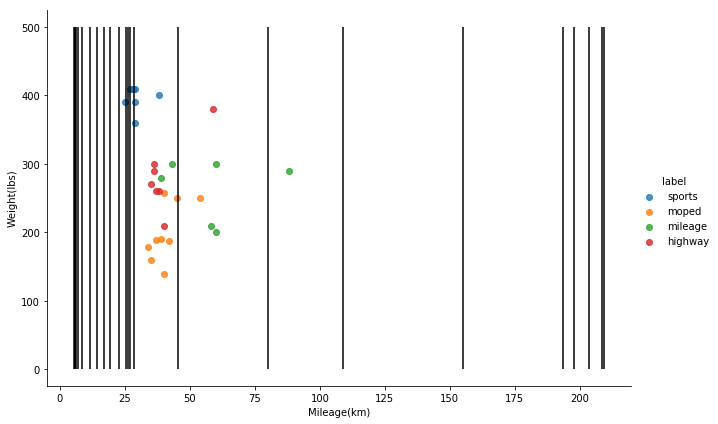

In [13]:
'''Plot describing the various potential splits'''
sns.lmplot(data=train_df, x="Mileage(km)",y="Weight(lbs)",hue="label",fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=potential_splits[3],ymin=1,ymax=500)
#plt.hlines(y=potential_splits[2],xmin=1,xmax=200)

### Split data

In [14]:
'''based on values from potential split, we create data below and data above that value'''
def split_data(data,split_column, split_value):
    split_column_values=data[:,split_column]
    data_above=data[split_column_values >split_value]
    data_below=data[split_column_values <=split_value] 
    return data_below,data_above

In [15]:
split_column=1
split_value=100
data

array([[150, 38, 190, 17.0, 'moped'],
       [310, 37, 300, 127.0, 'highway'],
       [310, 36, 288, 28.0, 'highway'],
       [249, 33, 240, 15.8, 'highway'],
       [125, 55, 240, 8.5, 'mileage'],
       [920, 32, 410, 190.0, 'sports'],
       [340, 34, 195, 150.0, 'highway'],
       [125, 60, 250, 12.0, 'mileage'],
       [125, 40, 180, 7.0, 'moped'],
       [1000, 31, 370, 75.0, 'sports'],
       [200, 55, 260, 7.4, 'mileage'],
       [270, 38, 280, 7.0, 'highway'],
       [280, 39, 286, 30.0, 'highway']], dtype=object)

In [16]:
data_below,data_above=split_data(data,split_column,split_value)
data_above

array([], shape=(0, 5), dtype=object)

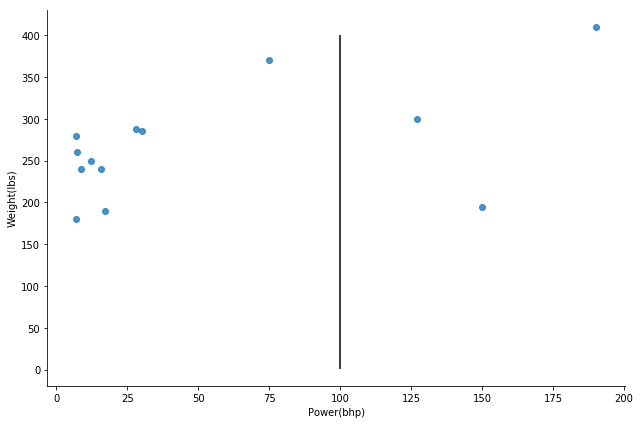

In [17]:
'''for separating one class from the rest'''
plotting_df=pd.DataFrame(data,columns=df.columns)
sns.lmplot(data=plotting_df,x="Power(bhp)",y="Weight(lbs)",fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=split_value,ymin=1,ymax=400)
#plt.xlim(55,)

### Lowest overall entropy

In [18]:
'''Entropy defines the overall disorderness of the system. Therefore more entropy means more data is scattered'''

def calculate_entropy(data):
    label_column=data[:,-1]
    _,counts=np.unique(label_column,return_counts=True)
    #print(counts)
    probabilities=counts/counts.sum()
    entropy=sum(probabilities * -np.log2(probabilities))   #entropy=weighted sum* uncertainity value
    return entropy

In [19]:
calculate_entropy(data_above)   #beacuse that classification is unique: i.e it contains only 1 label

#'''Entropy >1 is also possible, that means it is highly disordered'''

0

In [20]:
def calculate_overall_entropy(data_below,data_above):
    n_data_points=len(data_below)+len(data_above)

    p_data_below=len(data_below)/n_data_points
    p_data_above=len(data_above)/n_data_points

    overall_entropy=(p_data_below * calculate_entropy(data_below)+ p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [21]:
'''Function to determine the best split out of many potential splits'''
def determine_best_split(data,potential_splits):
    
    overall_entropy=999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below,data_above=split_data(data,split_column=column_index,split_value=value)
            current_overall_entropy=calculate_overall_entropy(data_below,data_above)
        
            if current_overall_entropy <= overall_entropy:
                overall_entropy=current_overall_entropy
                best_split_column=column_index
                best_split_value=value
    
    return best_split_column,best_split_value

In [22]:
determine_best_split(data,potential_splits)

(0, 234.5)

## Decision Tree Algorithm

subtree={question:[yes_answer,no_answer]}
example_tree={"Power(bhp) >100":["sports",{"Weight(lbs) <200":["moped",{"mileage(km) >50":["mileage","highway"]}]}]}

### Algorithm

In [23]:
'''Main algorithm'''
def decision_tree_algorithm(df,counter=0,min_samples=2,max_depth=5):
    #data preparation
    if counter==0:
        global COLUMN_HEADERS
        COLUMN_HEADERS=df.columns
        data=df.values
    else:
        data=df
    #base case
    if (check_purity(data)) or (len(data) < min_samples) or (counter==max_depth):
        classification=classify_data(data)
        return classification
    #recursive block
    else:
        counter+=1
        #helper functions
        potential_splits=get_potential_splits(data)
        split_column,split_value=determine_best_split(data,potential_splits)
        data_below,data_above=split_data(data,split_column,split_value)
        
        #instantiate subtree
        feature_name=COLUMN_HEADERS[split_column]
        question="{} <= {}".format(feature_name,split_value)
        sub_tree={question: []}
        
        #find_answers(recursion)
        yes_answer=decision_tree_algorithm(data_below,counter,min_samples,max_depth)
        no_answer=decision_tree_algorithm(data_above,counter,min_samples,max_depth)
        
        if yes_answer==no_answer:
            sub_tree=yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree
        

In [44]:
tree=decision_tree_algorithm(train_df,max_depth=4)#[train_df.label!="sports"])
pprint(tree)#pruning the tree

{'Engine(cc) <= 234.5': [{'Mileage(km) <= 54.5': [{'Weight(lbs) <= 278.5': ['moped',
                                                                            'mileage']},
                                                  'mileage']},
                         {'Weight(lbs) <= 345.0': [{'Engine(cc) <= 259.5': [{'Power(bhp) <= 18.05': ['highway',
                                                                                                     'mileage']},
                                                                            'highway']},
                                                   'sports']}]}


### classification

In [45]:
'''For an example test dataset'''
example=test_df.iloc[1]
example

Engine(cc)                   90
Mileage(km)                  40
Weight(lbs)                 140
Power(bhp)                  5.5
label                     moped
classification            moped
classification_correct     True
Name: 39, dtype: object

In [46]:
def classify_example(example,tree):
    question=list(tree.keys())[0]
    feature_name,comparison_operator,value=question.split()

    #ask question
    if example[feature_name]<=float(value):
        answer=tree[question][0]
    else:
        answer=tree[question][1]

    #base case
    if not isinstance(answer,dict):
        return answer

    #recursive function
    else: 
        residual_tree=answer
        return classify_example(example,residual_tree)

In [27]:
classify_example(example,tree)

'sports'

In [28]:
#example["Price(Rs)"]<=130000

## Accuracy

In [47]:
'''Function to calculate accuracy'''
def calculate_accuracy(df,tree):
    df["classification"]=df.apply(classify_example,axis=1,args=(tree,))
    df["classification_correct"]=df.classification==df.label
    
    accuracy=df.classification_correct.mean()
    return accuracy

In [48]:
calculate_accuracy(test_df,tree)

0.9230769230769231

In [31]:
'''To check what rows resulted in incorrect classification'''
test_df

,Engine(cc),Mileage(km),Weight(lbs),Power(bhp),label,classification,classification_correct
5,150,38,190,17.0,moped,moped,True
32,310,37,300,127.0,highway,sports,False
35,310,36,288,28.0,highway,highway,True
16,249,33,240,15.8,highway,moped,False
42,125,55,240,8.5,mileage,moped,False
14,920,32,410,190.0,sports,sports,True
38,340,34,195,150.0,highway,sports,False
15,125,60,250,12.0,mileage,moped,False
29,125,40,180,7.0,moped,moped,True
17,1000,31,370,75.0,sports,sports,True


In [32]:
pprint(tree)

{'Engine(cc) <= 269.5': [{'Weight(lbs) <= 268.5': ['moped', 'mileage']},
                         {'Power(bhp) <= 74.5': ['highway', 'sports']}]}


In [41]:
'''Overall algorithm summarised in 3 steps, to avoid ranom.seed(0) function'''

train_df, test_df=train_test_split(df,test_size=0.3)

tree=decision_tree_algorithm(train_df,max_depth=3)

accuracy=calculate_accuracy(test_df,tree)

pprint(tree)
pprint(accuracy)

[20, 39, 7, 31, 37, 21, 12, 15, 1, 17, 40, 14, 11]
{'Engine(cc) <= 234.5': [{'Mileage(km) <= 54.5': [{'Weight(lbs) <= 278.5': ['moped',
                                                                            'mileage']},
                                                  'mileage']},
                         {'Weight(lbs) <= 345.0': ['highway', 'sports']}]}
0.9230769230769231
